# Sales Analysis

## Sanity Check

In [1]:
import json

def load_config(file_path: str = "./config.json"):
    with open(file_path) as config_file:
        data = json.load(config_file)
    return data

config = load_config("../config.json")
DBNAME = config.get("DBNAME")
HOSTNAME = config.get("HOSTNAME")
USER = config.get("USER")
PASS = config.get("PASS")
SCHEMA = config.get("SCHEMA")

In [2]:
# Basic 
import sys
import numpy as np
import scipy as sp
import pandas as pd

# SQL Engine
import psycopg2
import pandas as pd
from sqlalchemy import create_engine

# Profiling process
from tqdm import tqdm

# Warning problems in notebook
import warnings
warnings.filterwarnings('ignore')

# Visualization
import bamboolib as bam

# Reporting result
import sweetviz as sv
from dataprep.eda import create_report

In [3]:
def handle_missing_mart(df):
    df['product_category'].fillna("Other", inplace=True)
    payment_val = (44990.0 + 2830.0) * 3
    df.loc[df.total_payment_value.isna(), 'total_payment_value'] = payment_val
    
    return df

In [4]:
# Load data

# Create an engine instance
alchemyEngine = create_engine(
    f'postgresql+psycopg2://{USER}:{PASS}@{HOSTNAME}/{DBNAME}', pool_recycle=3600)

# Connect to PostgreSQL server
conn = alchemyEngine.connect()

schema = SCHEMA

In [47]:
# Init needed data

QUERY = """
-- Data Mart 1 
-- Sales Trend Analysis Datamart
select 
	foi.order_id ,
	foi.order_item_id ,
	u.user_name,
	p.product_id ,
	p.product_category ,
	foi.price,
	foi.shipping_cost ,
	foi.total_payment_value ,
	dd."date" ,
	dd.day_of_year ,
	dd.day_of_month ,
	dd.day_of_quarter ,
	dd.day_name ,
	dd.day_of_week ,
	dd.month_actual ,
	dd.month_name ,
	dd.week_of_month ,
	dd."year" ,
	dd."isWeekend" ,
	dt."hour" 
from staging.fct_order_items foi
left outer join staging.dim_date dd on foi.order_date = dd.date_id 
left outer join staging.dim_time dt on foi.order_time = dt.time_id 
left outer join (
	select 
		du.user_key ,
		du.user_name
	from staging.dim_user du 
	where du.is_current_version=true
) u on foi.user_key = u.user_key
left outer join (
	select 
		dp.product_key ,
		dp.product_id , 
		dp.product_category 
	from staging.dim_product dp 
	where dp.is_current_version=true
) p on foi.product_key = p.product_key;
"""

# Init dataframe
df = pd.read_sql_query(QUERY, conn)
df = handle_missing_mart(df)
df

order_id  order_item_id  \
0       00018f77f2f0320c557190d7a144bdd3              1   
1       00024acbcdf0a6daa1e931b038114c75              1   
2       00042b26cf59d7ce69dfabb4e55b4fd9              1   
3       00048cc3ae777c65dbb7d2a0634bc1ea              1   
4       0005a1a1728c9d785b8e2b08b904576c              1   
...                                  ...            ...   
112645  fffb9224b6fc7c43ebb0904318b10b5f              3   
112646  fffb9224b6fc7c43ebb0904318b10b5f              4   
112647  fffbee3b5462987e66fb49b1c5411df2              1   
112648  fffcd46ef2263f404302a634eb57f7eb              1   
112649  fffe41c64501cc87c801fd61db3f6244              1   

                               user_name                        product_id  \
0       eb28e67c4c0b83846050ddfb8a35d051  e5f2d52b802189ee658865ca93d83a8f   
1       af861d436cfc08b2c2ddefd0ba074622  7634da152a4610f1595efa32f14722fc   
2       64b576fb70d441e8f1b2d7d446e483c5  ac6c3623068f30de03045865e4e10089   
3       85c835d128beae5b4ce8602c491bf385  ef92defde845ab8450f9d70c526ef70f   
4       639d23421f5517f69d0c3d6e6564cf0e  310ae3c140ff94b03219ad0adc3c778f   
...                                  ...                               ...   
112645  f736308cd9952b33b90b9fe94da9c8f5  43423cdffde7fda63d0414ed38c11a73   
112646  f736308cd9952b33b90b9fe94da9c8f5  43423cdffde7fda63d0414ed38c11a73   
112647  ecc3d4eb9b17d2f0865d21f2abecc51c  6f0169f259bb0ff432bfff7d829b9946   
112648  0da9fe112eae0c74d3ba1fe16de0988b  32e07fd915822b0765e448c4dd74c828   
112649  cd76a00d8e3ca5e6ab9ed9ecb6667ac4  350688d9dc1e75ff97be326363655e01   

             product_category     price  shipping_cost  total_payment_value  \
0                    pet_shop  239900.0        19930.0             259830.0   
1                   perfumery   12990.0        12790.0              25780.0   
2                garden_tools  199900.0        18140.0             218040.0   
3                  housewares   21900.0        12690.0              34590.0   
4               health_beauty  145950.0        11650.0             157600.0   
...                       ...       ...            ...                  ...   
112645          watches_gifts   55000.0        34190.0             356760.0   
112646          watches_gifts   55000.0        34190.0             356760.0   
112647      home_construction  119850.0        20030.0             139880.0   
112648  computers_accessories  350000.0        36530.0             386530.0   
112649         bed_bath_table   43000.0        12790.0              55790.0   

              date  day_of_year  day_of_month  day_of_quarter   day_name  \
0       2017-04-26        116.0            26              26  Wednesday   
1       2018-08-08        220.0             8              39  Wednesday   
2       2017-02-04         35.0             4              35  Saturday    
3       2017-05-15        135.0            15              45  Monday      
4       2018-03-19         78.0            19              78  Monday      
...            ...          ...           ...             ...        ...   
112645  2017-10-27        300.0            27              27  Friday      
112646  2017-10-27        300.0            27              27  Friday      
112647  2018-06-19        170.0            19              80  Tuesday     
112648  2018-07-14        195.0            14              14  Saturday    
112649  2018-06-09        160.0             9              70  Saturday    

        day_of_week  month_actual month_name  week_of_month    year  \
0                 3           4.0  April                  4  2017.0   
1                 3           8.0  August                 2  2018.0   
2                 6           2.0  February               1  2017.0   
3                 1           5.0  May                    3  2017.0   
4                 1           3.0  March                  3  2018.0   
...             ...           ...        ...            ...     ...   
112645            5        

In [39]:
# Grouping
order_grouped_year = df.groupby(['year', 'day_of_year']).agg(total_transaction_val=('price', 'sum'), 
                                                             num_of_transaction=('order_id', 'size')).reset_index()
order_grouped_year

year  day_of_year  total_transaction_val  num_of_transaction
0    2016.0        248.0                72890.0                   2
1    2016.0        249.0                59500.0                   1
2    2016.0        259.0               134970.0                   3
3    2016.0        276.0               100000.0                   1
4    2016.0        277.0               463480.0                   8
..      ...          ...                    ...                 ...
611  2018.0        238.0              8070710.0                  82
612  2018.0        239.0              5345910.0                  71
613  2018.0        240.0              3673910.0                  45
614  2018.0        241.0              1546040.0                  16
615  2018.0        246.0               145000.0                   1

[616 rows x 4 columns]

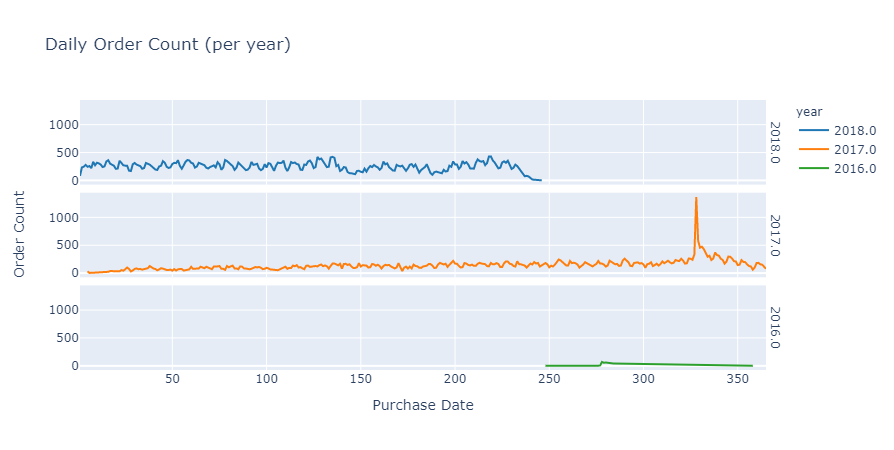

In [40]:
import plotly.express as px
fig = px.line(order_grouped_year.sort_values(by=['day_of_year'], ascending=[True]), 
              x='day_of_year', y='num_of_transaction', 
              color_discrete_sequence=px.colors.qualitative.D3, color='year', 
              facet_row="year",
              line_dash_sequence=['solid'], title='Daily Order Count (per year)', 
              )
fig.update_yaxes(title_text='Order Count')
fig.update_xaxes(title_text='Purchase Date')
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))

# To remove the unnecessary title
fig['layout']['yaxis']['title']['text']=''
fig['layout']['yaxis3']['title']['text']=''

fig['layout']['xaxis3']['title']['text']=''
fig['layout']['xaxis2']['title']['text']=''

fig

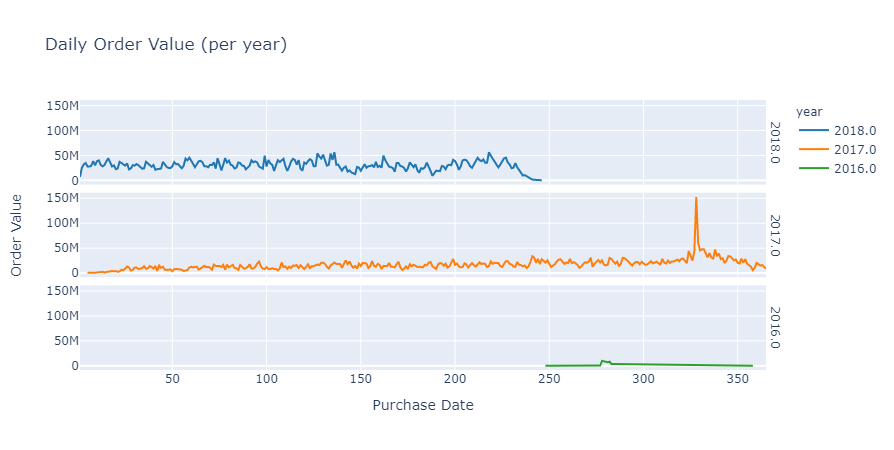

In [41]:
import plotly.express as px
fig = px.line(order_grouped_year.sort_values(by=['day_of_year'], ascending=[True]), 
              x='day_of_year', y='total_transaction_val', 
              color_discrete_sequence=px.colors.qualitative.D3, color='year', 
              facet_row="year",
              line_dash_sequence=['solid'], title='Daily Order Value (per year)', 
              facet_col_spacing=0.1)
fig.update_xaxes(title_text='Purchase Date')
fig.update_yaxes(title_text='Order Value')

fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))

# To remove the unnecessary title
fig['layout']['yaxis']['title']['text']=''
fig['layout']['yaxis3']['title']['text']=''

fig['layout']['xaxis3']['title']['text']=''
fig['layout']['xaxis2']['title']['text']=''

fig

In [43]:
# Grouping continuous
order_grouped_cont = df.groupby(['date']).agg(year=('year', 'max'),total_transaction_val=('price', 'sum'), num_of_transaction=('order_id', 'size')).reset_index()
order_grouped_cont

date    year  total_transaction_val  num_of_transaction
0    2016-09-04  2016.0                72890.0                   2
1    2016-09-05  2016.0                59500.0                   1
2    2016-09-15  2016.0               134970.0                   3
3    2016-10-02  2016.0               100000.0                   1
4    2016-10-03  2016.0               463480.0                   8
..          ...     ...                    ...                 ...
611  2018-08-26  2018.0              8070710.0                  82
612  2018-08-27  2018.0              5345910.0                  71
613  2018-08-28  2018.0              3673910.0                  45
614  2018-08-29  2018.0              1546040.0                  16
615  2018-09-03  2018.0               145000.0                   1

[616 rows x 4 columns]

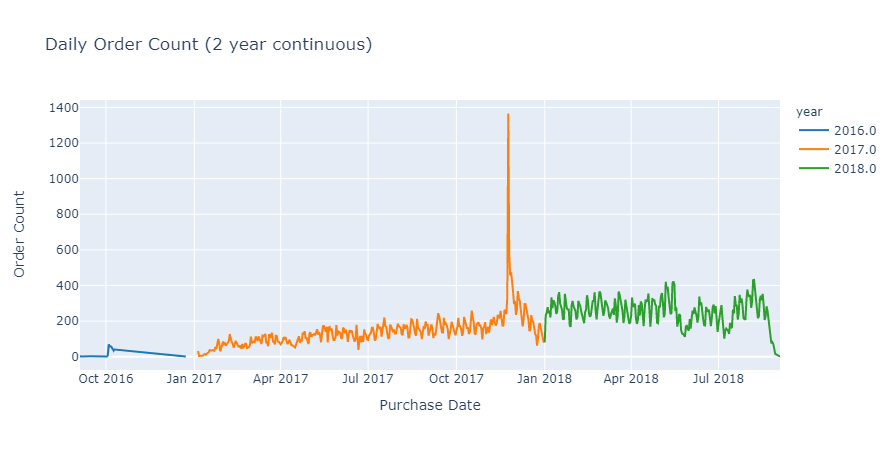

In [44]:
fig = px.line(order_grouped_cont.sort_values(by=['date'], ascending=[True]), 
              x='date', y='num_of_transaction', 
              color_discrete_sequence=px.colors.qualitative.D3, 
              color='year', 
              line_dash_sequence=['solid'], 
              title='Daily Order Count (2 year continuous)', 
              facet_col_spacing=0.1)
fig.update_xaxes(title_text='Purchase Date')
fig.update_yaxes(title_text='Order Count')
fig

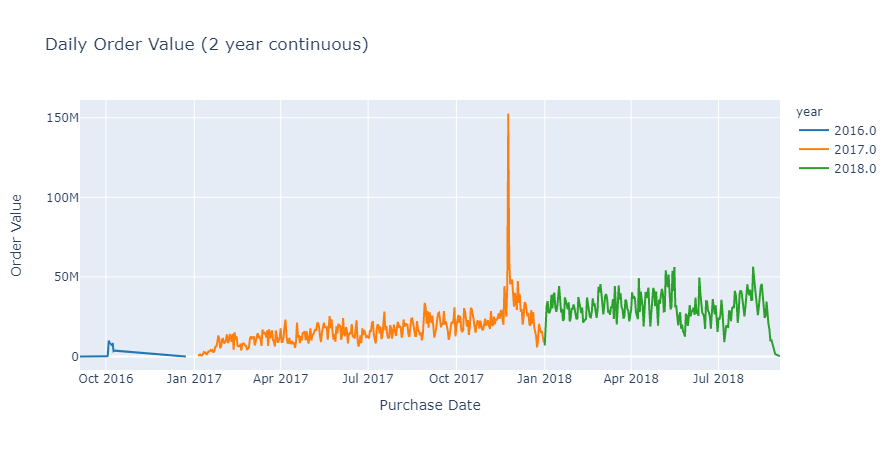

In [45]:
fig = px.line(order_grouped_cont.sort_values(by=['date'], ascending=[True]), 
              x='date', y='total_transaction_val', 
              color_discrete_sequence=px.colors.qualitative.D3, 
              color='year', 
              line_dash_sequence=['solid'], 
              title='Daily Order Value (2 year continuous)', 
              facet_col_spacing=0.1)
fig.update_xaxes(title_text='Purchase Date')
fig.update_yaxes(title_text='Order Value')
fig

Make more sense, the data seperate beautifully, need to find the reason for peaking in Dec 24 2017

Hipotesa : E commerce berkembang terus  -> correct

Problem :
- Some data is missing

--
Some mystery:
- Is dis even blibli data? -> Blibli start at 2011, meanwhile from the data, it seems like it start from Oct 2016.
- BliPay?


In [54]:
# Grouping
order_date_groupby = df.groupby(['date']).agg(**{"total_payment_value": ('total_payment_value', 'sum'), 
                                                 "total_num_order": ('order_id', 'size'), 
                                                 "month_name": ('month_name', 'last'), 
                                                 "day_name": ('day_name', 'last'), 
                                                 "day_of_week": ('day_of_week', 'last'), 
                                                 "day_of_month": ('day_of_month', 'last'), 
                                                 "year": ('year', 'last'), 
                                                 "month_actual": ('month_actual', 'last'), 
                                                 "isWeekend": ('isWeekend', 'last'),
                                                 "hour": ('hour', 'last')
                                                }).reset_index()
order_date_groupby

date  total_payment_value  total_num_order month_name   day_name  \
0    2016-09-04             272460.0                2  September  Sunday      
1    2016-09-05              75060.0                1  September  Monday      
2    2016-09-15                  0.0                3  September  Thursday    
3    2016-10-02             109340.0                1  October    Sunday      
4    2016-10-03             595140.0                8  October    Monday      
..          ...                  ...              ...        ...        ...   
611  2018-08-26           10496350.0               82  August     Sunday      
612  2018-08-27            6720780.0               71  August     Monday      
613  2018-08-28            5012700.0               45  August     Tuesday     
614  2018-08-29            4262660.0               16  August     Wednesday   
615  2018-09-03             166460.0                1  September  Monday      

     day_of_week  day_of_month    year  month_actual  isWeekend  hour  
0              7             4  2016.0           9.0       True    21  
1              1             5  2016.0           9.0      False     0  
2              4            15  2016.0           9.0      False    12  
3              7             2  2016.0          10.0       True    22  
4              1             3  2016.0          10.0      False    22  
..           ...           ...     ...           ...        ...   ...  
611            7            26  2018.0           8.0       True    20  
612            1            27  2018.0           8.0      False     9  
613            2            28  2018.0           8.0      False     9  
614            3            29  2018.0           8.0      False     9  
615            1             3  2018.0           9.0      False     9  

[616 rows x 11 columns]

In [62]:
order_monthly_groupby = order_date_groupby.groupby(['month_actual']).agg(avg_payment_value=('total_payment_value', 'mean'), avg_num_order=('total_num_order', 'mean')).reset_index()
order_monthly_groupby

month_actual  avg_payment_value  avg_num_order
0            1.0       2.751974e+07     157.982759
1            2.0       2.946756e+07     171.839286
2            3.0       3.229938e+07     180.919355
3            4.0       3.337462e+07     177.650000
4            5.0       3.599160e+07     194.532258
5            6.0       3.163913e+07     177.683333
6            7.0       3.369352e+07     187.274194
7            8.0       3.499583e+07     202.633333
8            9.0       2.989305e+07     142.294118
9           10.0       2.737710e+07     142.125000
10          11.0       5.279563e+07     288.833333
11          12.0       3.258986e+07     197.156250

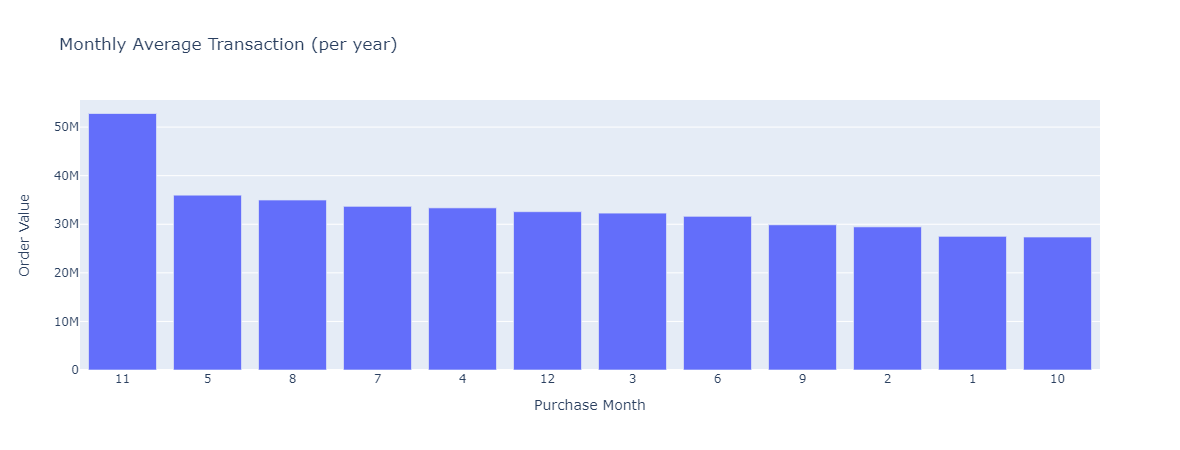

In [80]:
fig = px.bar(order_monthly_groupby, x='month_actual', y='avg_payment_value', title="Monthly Average Transaction (per year)")
fig.update_xaxes(categoryorder='total descending', type='category')
fig.update_xaxes(title_text='Purchase Month')
fig.update_yaxes(title_text='Order Value')
fig

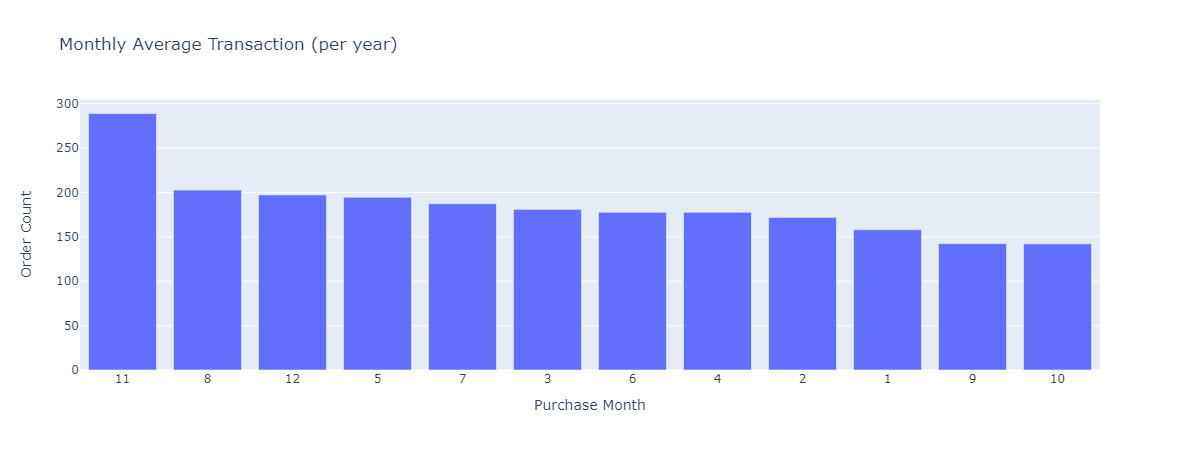

In [81]:
fig = px.bar(order_monthly_groupby, x='month_actual', y='avg_num_order', title="Monthly Average Transaction (per year)")
fig.update_xaxes(categoryorder='total descending', type='category')
fig.update_xaxes(title_text='Purchase Month')
fig.update_yaxes(title_text='Order Count')
fig

In [58]:
order_weekly_groupby = order_date_groupby.groupby(['day_of_week']).agg(avg_payment_value=('total_payment_value', 'mean'), avg_num_order=('total_num_order', 'mean')).reset_index()
order_weekly_groupby

year  day_of_week  avg_payment_value  avg_num_order
0   2016.0            1       1.858950e+06      16.333333
1   2016.0            2       1.345614e+07      69.000000
2   2016.0            3       1.575329e+07      56.000000
3   2016.0            4       5.656255e+06      30.500000
4   2016.0            5       5.200465e+06      26.500000
5   2016.0            6       1.050511e+07      45.000000
6   2016.0            7       2.425630e+06      12.333333
7   2017.0            1       2.849443e+07     159.509804
8   2017.0            2       2.886594e+07     159.725490
9   2017.0            3       2.728839e+07     149.784314
10  2017.0            4       2.552298e+07     141.903846
11  2017.0            5       2.920208e+07     150.173077
12  2017.0            6       1.933412e+07     108.442308
13  2017.0            7       1.909188e+07     117.634615
14  2018.0            1       5.154396e+07     283.583333
15  2018.0            2       5.219155e+07     286.342857
16  2018.0            3       4.998856e+07     283.000000
17  2018.0            4       5.166933e+07     275.205882
18  2018.0            5       4.359562e+07     240.500000
19  2018.0            6       3.325066e+07     190.705882
20  2018.0            7       3.739689e+07     213.588235

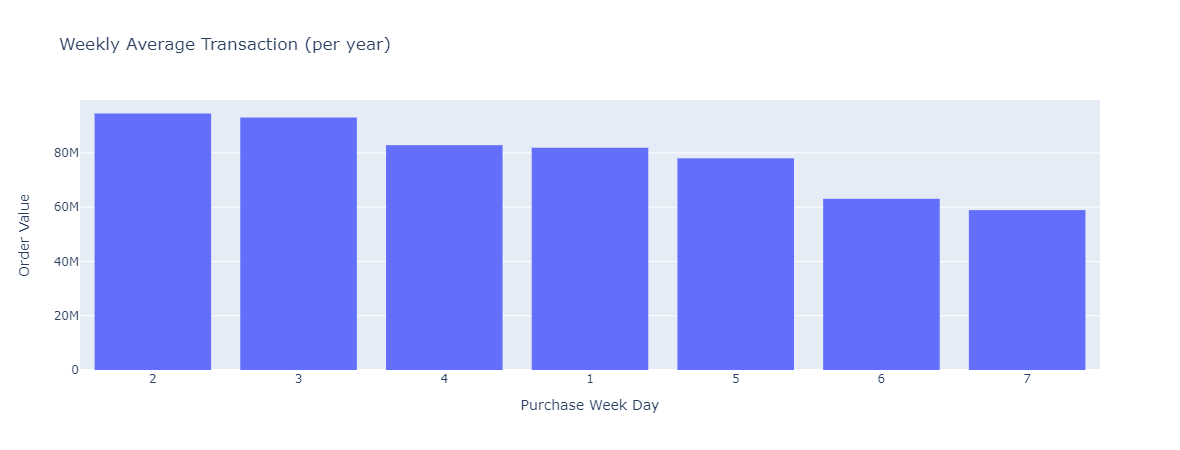

In [83]:
fig = px.histogram(order_weekly_groupby, x='day_of_week', y='avg_payment_value', 
             title="Weekly Average Transaction (per year)",
            )
fig.update_xaxes(categoryorder='total descending', type='category')
fig.update_xaxes(title_text='Purchase Week Day')
fig.update_yaxes(title_text='Order Value')
fig

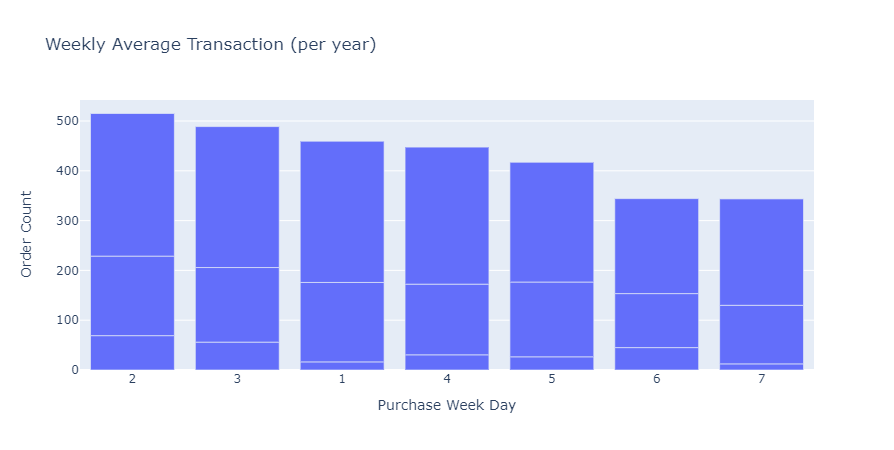

In [78]:
fig = px.bar(order_weekly_groupby, x='day_of_week', y='avg_num_order', title="Weekly Average Transaction")
fig.update_xaxes(categoryorder='total descending', type='category')
fig.update_xaxes(title_text='Purchase Week Day')
fig.update_yaxes(title_text='Order Count')
fig

In [59]:
order_day_monthly_groupby = order_date_groupby.groupby(['day_of_month']).agg(avg_payment_value=('total_payment_value', 'mean'), avg_num_order=('total_num_order', 'mean')).reset_index()
order_day_monthly_groupby

year  day_of_month  avg_payment_value  avg_num_order
0   2016.0             2       1.093400e+05       1.000000
1   2016.0             3       5.951400e+05       8.000000
2   2016.0             4       6.864300e+06      35.500000
3   2016.0             5       7.914175e+06      28.500000
4   2016.0             6       1.131251e+07      58.000000
..     ...           ...                ...            ...
68  2018.0            27       4.130222e+07     219.625000
69  2018.0            28       3.854022e+07     208.500000
70  2018.0            29       3.217976e+07     185.428571
71  2018.0            30       4.177326e+07     231.500000
72  2018.0            31       4.853410e+07     250.000000

[73 rows x 4 columns]

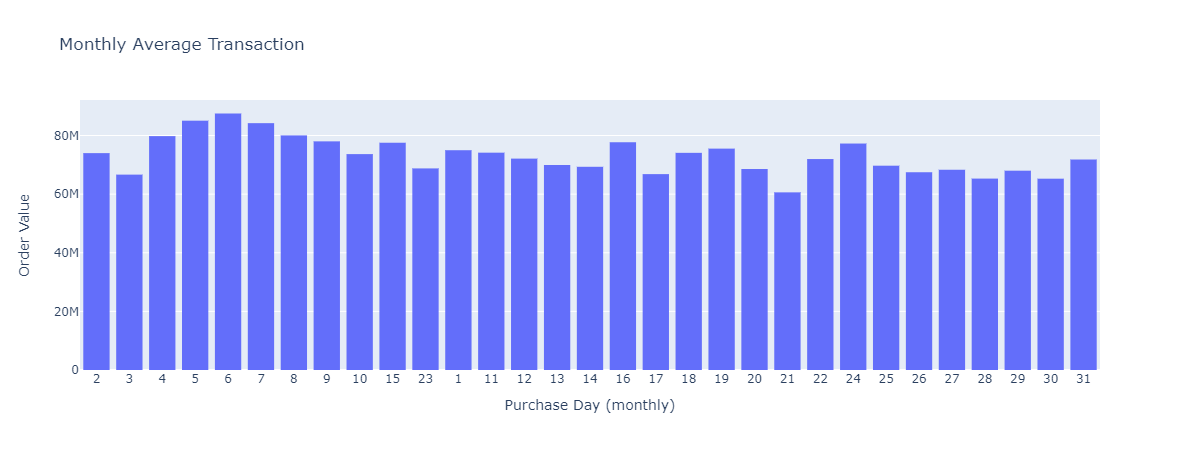

In [89]:
fig = px.histogram(order_day_monthly_groupby, x='day_of_month', y='avg_payment_value', 
             title="Monthly Average Transaction",
            )
fig.update_xaxes(type='category')
# To sorting : Uncomment below
# fig.update_xaxes(categoryorder='total descending')
fig.update_xaxes(title_text='Purchase Day (monthly)')
fig.update_yaxes(title_text='Order Value')
fig

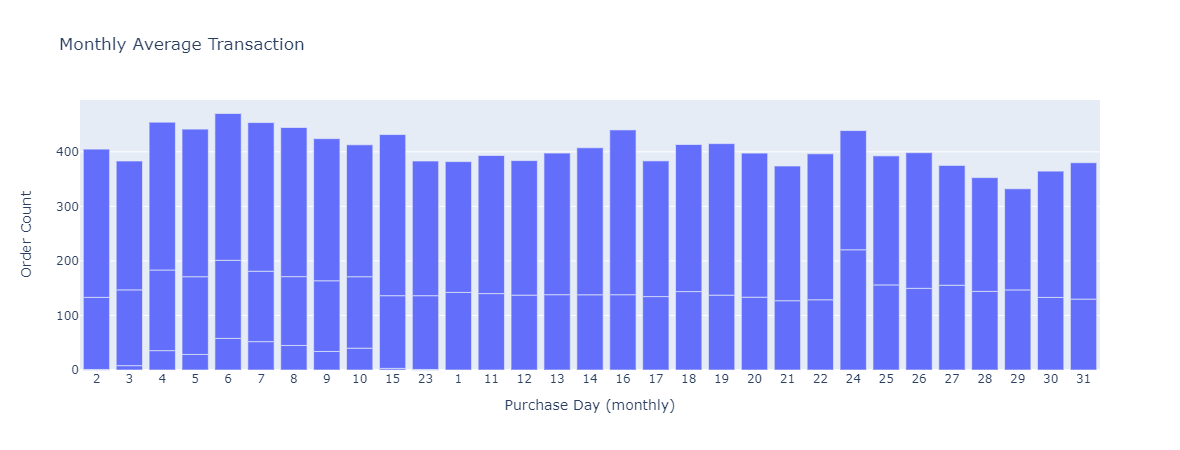

In [97]:
fig = px.bar(order_day_monthly_groupby, x='day_of_month', y='avg_num_order', title="Monthly Average Transaction")
fig.update_xaxes( type='category')
# To sorting : Uncomment below
# fig.update_xaxes(categoryorder='total descending')
fig.update_xaxes(title_text='Purchase Day (monthly)')
fig.update_yaxes(title_text='Order Count')
fig

In [90]:
order_weekend_groupby = order_date_groupby.groupby(['isWeekend']).agg(avg_payment_value=('total_payment_value', 'mean'), avg_num_order=('total_num_order', 'mean')).reset_index()
order_weekend_groupby

isWeekend  avg_payment_value  avg_num_order
0      False       3.611405e+07     197.877273
1       True       2.510199e+07     145.363636

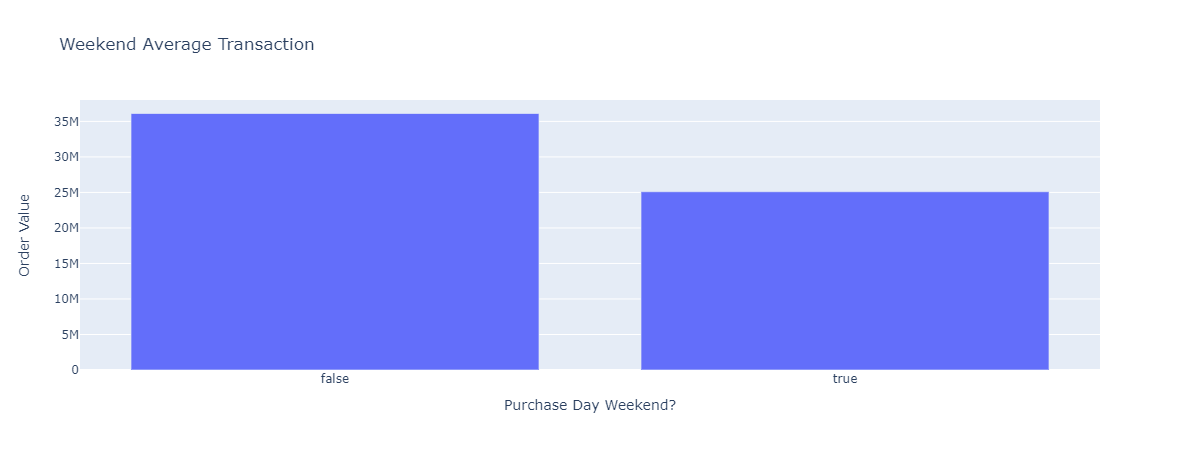

In [102]:
fig = px.bar(order_weekend_groupby, x='isWeekend', y='avg_payment_value', 
             title="Weekend Average Transaction"  
            )
fig.update_xaxes(type='category')
# To sorting : Uncomment below
# fig.update_xaxes(categoryorder='total descending')
fig.update_xaxes(title_text='Purchase Day Weekend?')
fig.update_yaxes(title_text='Order Value')
fig

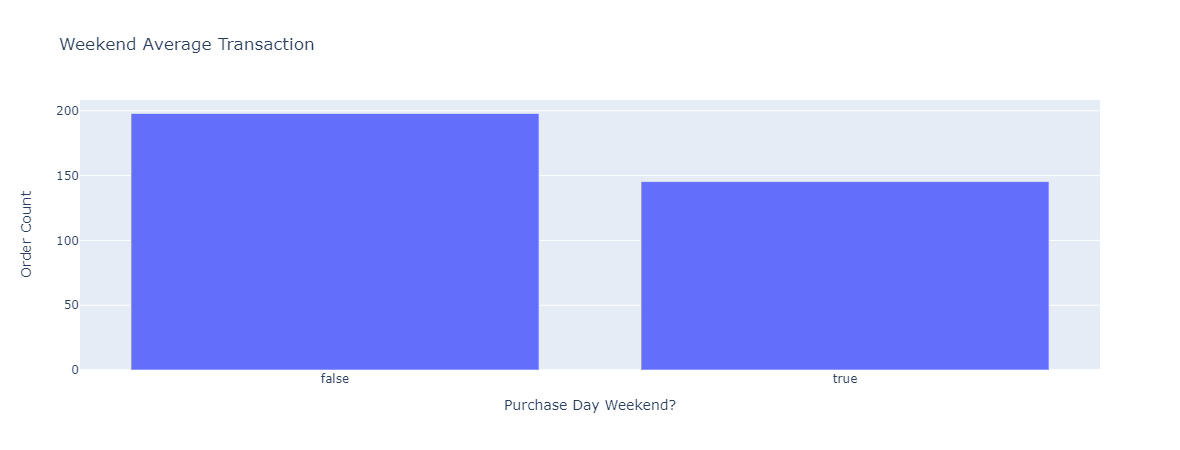

In [103]:
fig = px.bar(order_weekend_groupby, x='isWeekend', y='avg_num_order', title="Weekend Average Transaction")
fig.update_xaxes( type='category')
# To sorting : Uncomment below
# fig.update_xaxes(categoryorder='total descending')
fig.update_xaxes(title_text='Purchase Day Weekend?')
fig.update_yaxes(title_text='Order Count')
fig

In [61]:
order_hourly_groupby = order_date_groupby.groupby(['hour']).agg(avg_payment_value=('total_payment_value', 'mean'), avg_num_order=('total_num_order', 'mean')).reset_index()
order_hourly_groupby

year  hour  avg_payment_value  avg_num_order
0   2016.0     0       5.693785e+06      29.500000
1   2016.0    11       1.050511e+07      45.000000
2   2016.0    12       2.453325e+06      21.500000
3   2016.0    14       1.038131e+07      52.000000
4   2016.0    21       2.724600e+05       2.000000
5   2016.0    22       5.485923e+06      21.666667
6   2016.0    23       6.790283e+06      34.666667
7   2017.0     0       2.690151e+07     144.666667
8   2017.0     1       3.503928e+07     193.250000
9   2017.0     2       1.726827e+07      89.250000
10  2017.0     3       1.444220e+07      92.500000
11  2017.0     5       2.548736e+07     121.500000
12  2017.0     6       3.189382e+07     174.000000
13  2017.0     7       2.460873e+07     142.857143
14  2017.0     8       2.357739e+07     129.500000
15  2017.0     9       1.872443e+07     108.043478
16  2017.0    10       2.640655e+07     149.312500
17  2017.0    11       2.892790e+07     161.214286
18  2017.0    12       2.299576e+07     133.629630
19  2017.0    13       2.970343e+07     159.740741
20  2017.0    14       2.043723e+07     114.900000
21  2017.0    15       2.458927e+07     133.238095
22  2017.0    16       2.418390e+07     135.333333
23  2017.0    17       1.979275e+07     107.789474
24  2017.0    18       2.320127e+07     141.880000
25  2017.0    19       2.608441e+07     154.500000
26  2017.0    20       3.153295e+07     164.000000
27  2017.0    21       4.034088e+07     193.761905
28  2017.0    22       2.143622e+07     133.045455
29  2017.0    23       2.729806e+07     150.857143
30  2018.0     0       4.427718e+07     235.000000
31  2018.0     1       5.390741e+07     261.000000
32  2018.0     2       5.920535e+07     334.000000
33  2018.0     5       4.880358e+07     251.000000
34  2018.0     6       3.806321e+07     237.000000
35  2018.0     7       3.900566e+07     224.000000
36  2018.0     8       3.769805e+07     210.833333
37  2018.0     9       3.388778e+07     196.562500
38  2018.0    10       4.772902e+07     264.473684
39  2018.0    11       5.242431e+07     276.444444
40  2018.0    12       4.246192e+07     237.842105
41  2018.0    13       4.174885e+07     240.062500
42  2018.0    14       4.956286e+07     256.222222
43  2018.0    15       4.426433e+07     248.300000
44  2018.0    16       5.124744e+07     286.642857
45  2018.0    17       4.982667e+07     266.200000
46  2018.0    18       5.193350e+07     273.916667
47  2018.0    19       4.323973e+07     253.090909
48  2018.0    20       4.327029e+07     244.761905
49  2018.0    21       4.993413e+07     287.500000
50  2018.0    22       4.828920e+07     272.238095
51  2018.0    23       3.621577e+07     215.125000

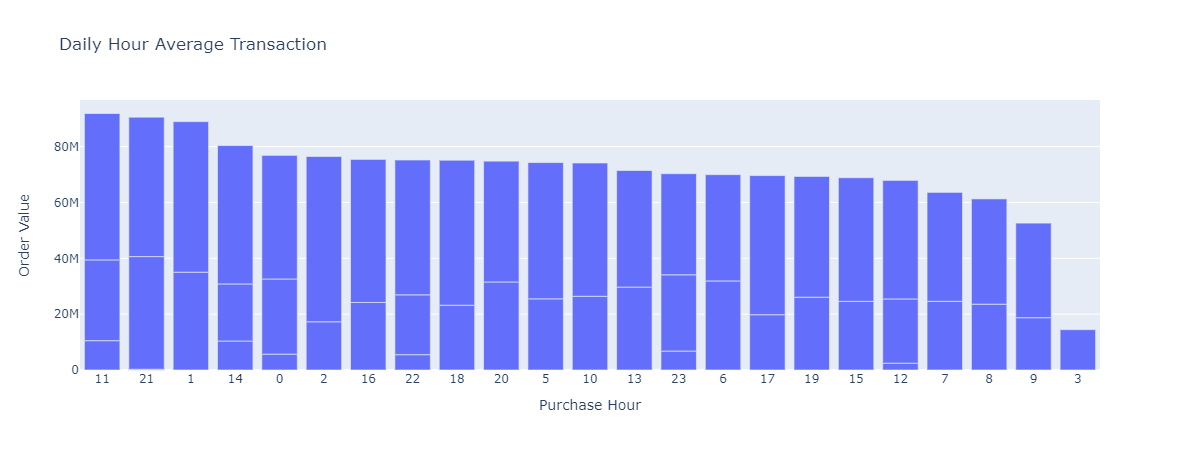

In [108]:
fig = px.bar(order_hourly_groupby, x='hour', y='avg_payment_value', 
             title="Daily Hour Average Transaction"  
            )
fig.update_xaxes(type='category')
# To sorting : Uncomment below
fig.update_xaxes(categoryorder='total descending')
fig.update_xaxes(title_text='Purchase Hour')
fig.update_yaxes(title_text='Order Value')
fig

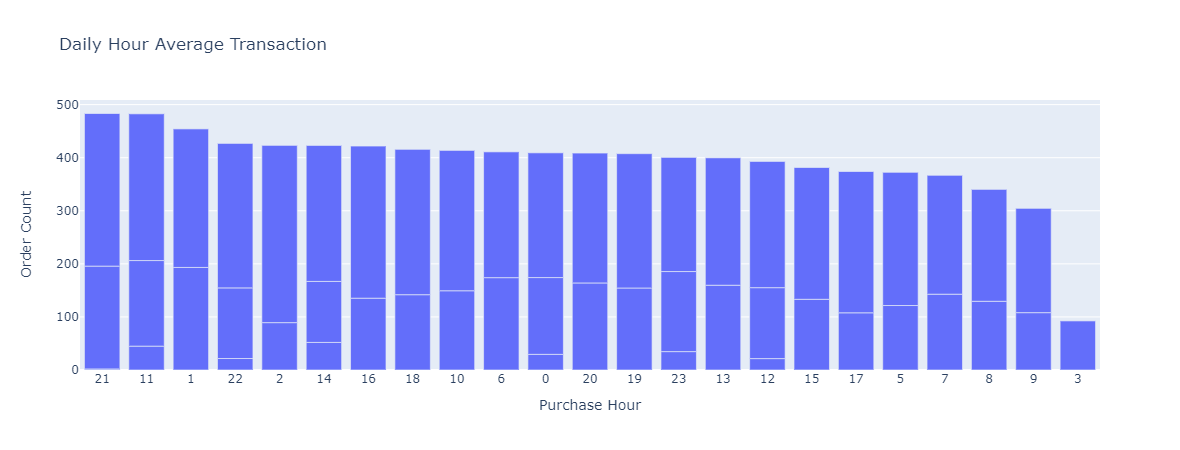

In [109]:
fig = px.bar(order_hourly_groupby, x='hour', y='avg_num_order', title="Daily Hour Average Transaction")
fig.update_xaxes( type='category')
# To sorting : Uncomment below
fig.update_xaxes(categoryorder='total descending')
fig.update_xaxes(title_text='Purchase Hour')
fig.update_yaxes(title_text='Order Count')
fig

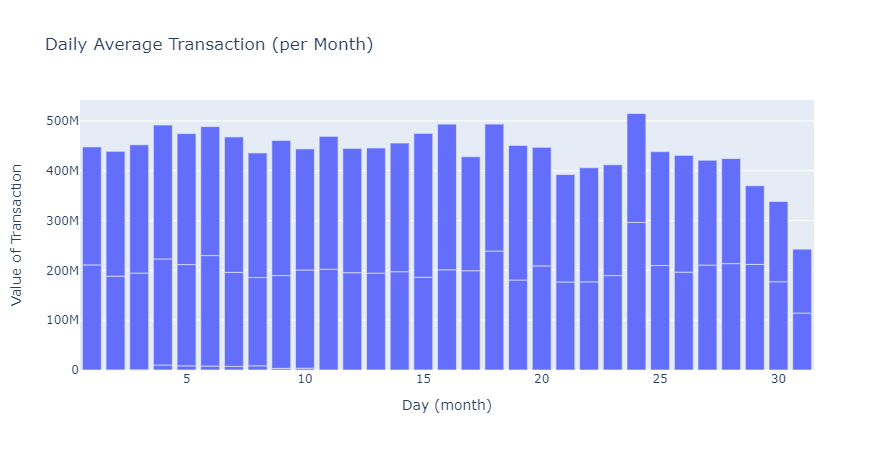

In [50]:
import plotly.express as px
fig = px.bar(order_grouped_month, y='num', x='day_of_month', title='Daily Average Transaction (per Month)')
fig.update_yaxes(title_text='Value of Transaction')
fig.update_xaxes(title_text='Day (month)')
fig

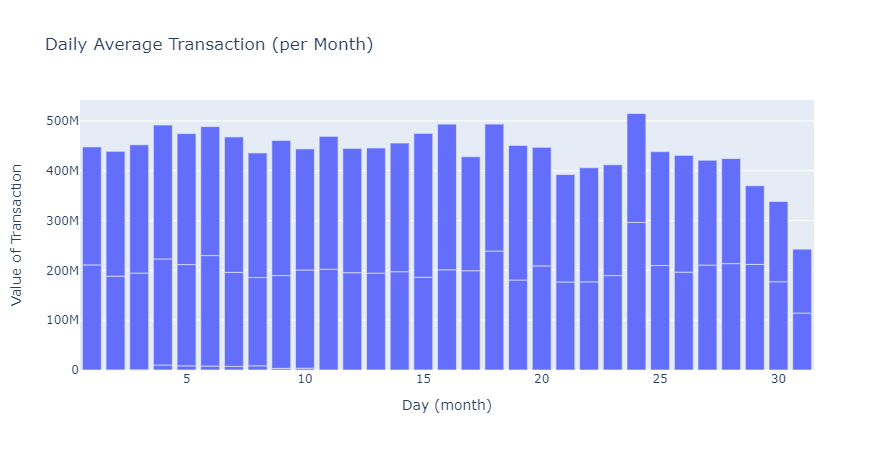

In [53]:
import plotly.express as px
fig = px.bar(order_grouped_month, y='total_transaction_val', x='day_of_month', title='Daily Average Transaction (per Month)')
fig.update_yaxes(title_text='Value of Transaction')
fig.update_xaxes(title_text='Day (month)')
fig